# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
import seaborn as sns
import matplotlib.dates as mdates
from dateutil import parser
import sys
import os
from sklearn.preprocessing import MinMaxScaler

# Dados Meteo

In [2]:
sys.path.append(os.path.abspath(".."))
from meteorology.data.meteorology_data import GetMeteorologyData
df = GetMeteorologyData()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29973 entries, 0 to 29972
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          29973 non-null  datetime64[ns]
 1   temp              29973 non-null  float64       
 2   feelslike         29973 non-null  float64       
 3   dew               29973 non-null  float64       
 4   humidity          29973 non-null  float64       
 5   precip            28966 non-null  float64       
 6   precipprob        29973 non-null  float64       
 7   preciptype        804 non-null    object        
 8   windgust          2088 non-null   float64       
 9   windspeed         29966 non-null  float64       
 10  winddir           29790 non-null  float64       
 11  sealevelpressure  29973 non-null  float64       
 12  cloudcover        22653 non-null  float64       
 13  visibility        29967 non-null  float64       
 14  conditions        2997

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Selecionar só as colunas temp e precip e fazer o resample diário com média
df = df[['temp', 'precip']].resample('D').mean()

# contadores corrigidos

In [4]:
df_corrigido_final = pd.read_csv(r"C:\Users\joana\Desktop\Projeto\construcao_modelos\df_corrigido_final.csv")

# Novo indice

In [33]:
def calcular_indice_uteis_fds(df, coluna='count_', plotar=True, cores=None):
    df = df.copy()
    df = df.set_index('datetime')

    # Separar dias úteis e não úteis com base na coluna exog
    df_uteis = df[df['exog'] != 1]
    df_nao_uteis = df[df['exog'] == 1]

    # Média semanal com resample
    media_uteis = df_uteis[coluna].resample('W-MON').mean()
    media_nao_uteis = df_nao_uteis[coluna].resample('W-MON').mean()

    # Combinar os dois em um único DataFrame
    medias = pd.concat([media_uteis, media_nao_uteis], axis=1)
    medias.columns = ['media_uteis', 'media_nao_uteis']
    medias = medias.dropna(how='all')  # remover semanas totalmente vazias

    # Calcular os índices
    medias['indice_uteis_não_uteis'] = medias['media_uteis'] / medias['media_nao_uteis']

    # Extrair ano e semana para plotagem
    medias['ano'] = medias.index.isocalendar().year
    medias['semana'] = medias.index.isocalendar().week

    if plotar:
        anos = sorted(medias['ano'].unique())
        if cores is None:
            cmap = plt.cm.tab10
            cores = {ano: cmap(i % 10) for i, ano in enumerate(anos)}

        plt.figure(figsize=(12, 6))

        for ano in anos:
            dados_ano = medias[medias['ano'] == ano]
            plt.plot(dados_ano['semana'], dados_ano['indice_uteis_não_uteis'],
                     marker='o', linestyle='-', label=f'Ano {ano}', color=cores[ano])

        plt.yscale('log', base=2)
        plt.axhline(1, color='red', linestyle='--', label='Índice = 1')
        plt.title('Índice: Média Úteis / Média Não Úteis (semanal, via resample)')
        plt.xlabel('Semana do Ano')
        plt.ylabel('Índice')
        plt.xlim(1, 53)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return medias

In [27]:
df_corrigido_final = df_corrigido_final.rename(columns={'detected': 'datetime'})
df_corrigido_final['datetime'] = pd.to_datetime(df_corrigido_final['datetime'])

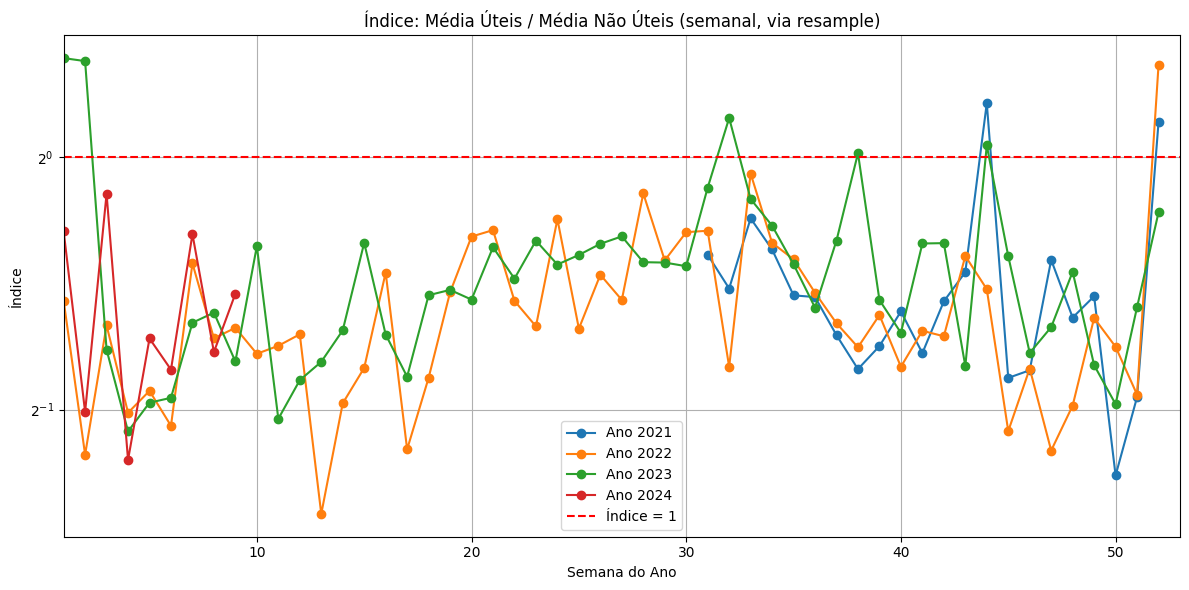

In [34]:
df_indices_uteis_não_uteis= calcular_indice_uteis_fds(df_corrigido_final, coluna='count_12', plotar=True)

### Novo indice + meteo

In [9]:
df.index = pd.to_datetime(df.index)
df_meteo_semanal = df.resample('W-MON').mean().reset_index()
df_meteo_semanal.columns = ['semana_data', 'temp', 'precip'] 

In [13]:
df_meteo_semanal

,semana_data,temp,precip
0,2021-08-02,21.135417,0.000000
1,2021-08-09,21.719048,0.000000
2,2021-08-16,24.116071,0.000000
3,2021-08-23,22.513095,0.000000
4,2021-08-30,21.120238,0.011185
...,...,...,...
175,2024-12-09,13.858929,0.023271
176,2024-12-16,8.967857,0.030797
177,2024-12-23,12.345833,0.029762
178,2024-12-30,10.432738,0.000000


In [35]:
df_indices_uteis_não_uteis = df_indices_uteis_não_uteis.reset_index()

In [36]:
df_indices_uteis_não_uteis.rename(columns={'datetime': 'semana_data'}, inplace=True)

In [37]:
df_indices_uteis_não_uteis

,semana_data,media_uteis,media_nao_uteis,indice_uteis_não_uteis,ano,semana
0,2021-08-02,1272.000000,1663.000000,0.764883,2021,31
1,2021-08-09,1126.600000,1616.000000,0.697153,2021,32
2,2021-08-16,1121.400000,1326.500000,0.845383,2021,33
3,2021-08-23,1142.400000,1472.000000,0.776087,2021,34
4,2021-08-30,1067.000000,1559.500000,0.684194,2021,35
...,...,...,...,...,...,...
131,2024-02-05,706.600000,1266.500000,0.557916,2024,6
132,2024-02-12,569.400000,703.500000,0.809382,2024,7
133,2024-02-19,752.250000,1284.666667,0.585560,2024,8
134,2024-02-26,705.200000,1026.000000,0.687329,2024,9


In [38]:
df_final = pd.merge(df_indices_uteis_não_uteis, df_meteo_semanal, on='semana_data', how='left')


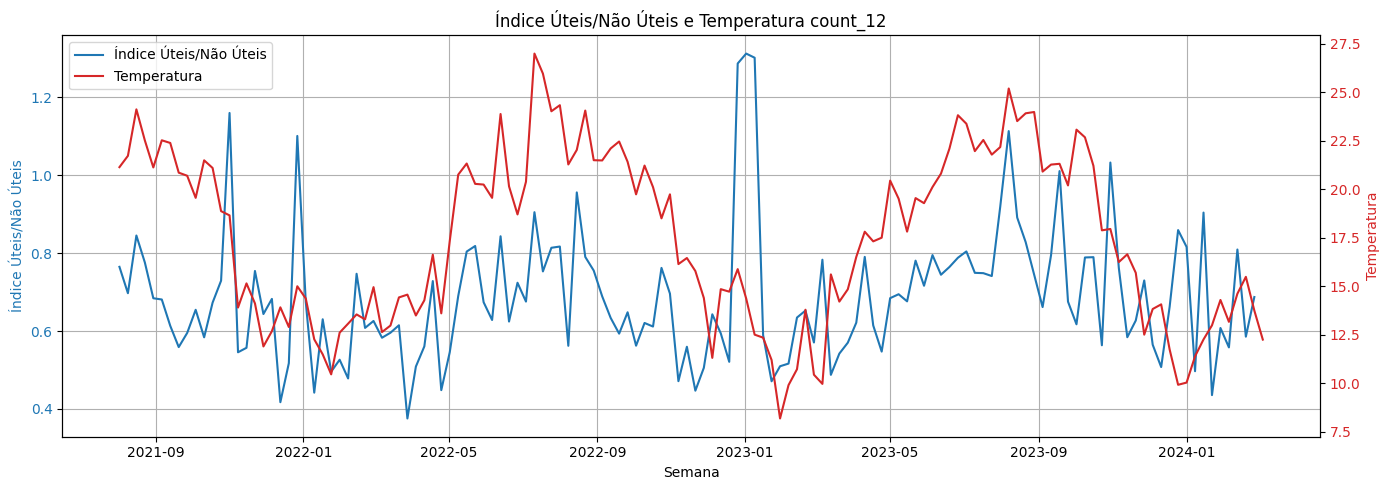

In [40]:


df_sorted = df_final.sort_values('semana_data').copy()

fig, ax1 = plt.subplots(figsize=(14,5))

# Gráfico para índice úteis/não úteis
ax1.plot(df_sorted['semana_data'], df_sorted['indice_uteis_não_uteis'], color='tab:blue', label='Índice Úteis/Não Úteis')
ax1.set_xlabel('Semana')
ax1.set_ylabel('Índice Úteis/Não Úteis', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Segundo eixo y para temperatura
ax2 = ax1.twinx()
ax2.plot(df_sorted['semana_data'], df_sorted['temp'], color='tab:red', label='Temperatura')
ax2.set_ylabel('Temperatura', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Índice Úteis/Não Úteis e Temperatura count_12')
ax1.grid(True)
fig.tight_layout()
plt.xticks(rotation=45)

# Legendas combinadas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()
